<a href="https://colab.research.google.com/github/TAJ-32/Projects/blob/main/Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.kaggle.com/general/156610
#This is how we import the dataset directly from kaggle.
from google.colab import files

files.upload()
!ls -lha kaggle.json
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets list
!kaggle datasets download theoviel/rsna-breast-cancer-512-pngs

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 66 Feb  2 00:02 kaggle.json
/content
ref                                                              title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset                Hotel Reservations Dataset                          480KB  2023-01-04 12:50:31           7135        249  1.0              
themrityunjaypathak/most-subscribed-1000-youtube-channels        Most Subscribed 1000 Youtube Channels                28KB  2023-01-21 14:42:05           1233         42  1.0              
senapatirajesh/netflix-tv-shows-and-movies                       Latest Netflix TV shows and movies                    1MB  2023-01-14 17:03:12       

In [ ]:
# This is meant to be the CNN for Breast Cancer Detection competition run by Kaggle and the Radiological Society of North America
#   as an extension GradCAM is implemented on the dataset such that we can see which parts of the image trigger a positive cancer detection

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as pyplot
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO, BytesIO, TextIOWrapper
from zipfile import ZipFile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from zipfile import ZipFile


In [ ]:
# Load the data (only csvs containing metadata) and stuff:
# Define data set of the metadata to make them iterable
class PatientMetaData():
    def __init__(self):
        self.all_meta_data  = pd.read_csv("train.csv") # I will send you this file that way you can upload it yourself, but it's too big to put on drive easily
        # Total dataset is around 57,000
        patient_image_ids = self.all_meta_data.iloc[:, 1:3] # Columns for patient ID, imageID, left "L" or right "R" breast
        cancer_labels  = self.all_meta_data.iloc[:,6]
        
        # Now convert the incoming data into tensors:
        self.all_x = torch.tensor(patient_image_ids.to_numpy(), dtype=torch.int)
        self.all_y = torch.tensor(cancer_labels.to_numpy(), dtype=torch.long) # since the probability output wil be in long format
        
        # And partition the data into testing and training sets:
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.all_x, self.all_y, test_size=0.2)
        self.n_samples = self.x_train.shape[0]
        
    def __getitem__(self, index):
        # Return patient ID, image ID, cancer bool for the training set
        patientID = self.x_train[index, 0].numpy()
        imageID = self.x_train[index, 1].numpy()
        filename = str(patientID) + "_" + str(imageID) + ".png" 
        return filename, self.y_train[index]
    
    def __len__(self):
        return self.n_samples
    
    def test_sets(self):
        return self.x_test.numpy(), self.y_test.numpy()

In [ ]:
# hyper parameters
num_epochs = 15
batch_size = 256
learning_rate = 0.0001

# Create the training data loader:
meta_dataset = PatientMetaData()
data_loader  = DataLoader(dataset=meta_dataset, batch_size = batch_size, shuffle=True)

In [ ]:
################## NOW DEFINE THE ARCHITECTURE OF THE CNN ############################
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(1, 3, 5), # Assuming 1 in channel (inputs are b&w), output channel size is 3 and kernels are 5x5
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Kernel size is 2x2 with stride of 2
            nn.Conv2d(3, 5, 5), # input channel size is equal to the last channel size, kernels are still 5x5
            nn.ReLU(),
            nn.MaxPool2d(2,2), # Kernel size is 2x2 with stride of 2
            nn.Conv2d(5, 5, 5),
            nn.ReLU()
        )
        self.block2 = nn.Sequential(
            nn.Linear(73205, 128), 
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    # We need to apply the hook before the last pooling layer and after all the convolutional layers
    
    # Code for the hook method of GradCAM is from:
    #   https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
    
    
    def forward(self, x):
        # Pass the input through the convolutional layers!
        x_internal = self.block1(x)
        
        # Record the gradients after the convolutional layers
        if x_internal.requires_grad:
          h = x_internal.register_hook(self.activations_hook)
        # Flatten the output
        x_internal = x_internal.view(-1, 73205)
        # And feed it to the fully connected layers
        y_pred = self.block2(x_internal)
        return y_pred
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation extraction
    def get_activations(self, x):
        return self.block1(x)

In [ ]:
def onehot(c):
    #Vector is one hot encoded with v_1 = negative , v_2 = positive
    v = torch.zeros(2)
    v[c] = 1
    return v

In [ ]:
# Code for creating model, loss function and optimizer
torch.cuda.empty_cache()
# Change our device to the gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
criterion = nn.CrossEntropyLoss(torch.tensor([1, 25], dtype=torch.float32)) #calculate our loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #use our optimizer
transform = transforms.Compose([transforms.ToTensor()]) #making our data into a tensor so that it can be more easily worked with
samples_zip = ZipFile("rsna-breast-cancer-512-pngs.zip")

In [ ]:
# TRAIN LOOP
# Images can be found here: "https://www.kaggle.com/datasets/radek1/rsna-mammography-images-as-pngs?select=images_as_pngs"
num_steps = len(data_loader) # Need to implement the train loader depending on what the data is
#print(num_steps)
for epoch in range(num_epochs):
    total_loss = 0
    num_iters = 0
    for i, (filepaths, c) in enumerate(data_loader):
        # image_tensors will eventually hold all the images in a given batch
        image_tensors = torch.empty([len(filepaths), 512, 512]) # len(filepaths) usually = batch size, but not when we reach the end of the data
        for j, filepath in enumerate(filepaths):
            # Get the current sample out of the zip file
            current_mammo = samples_zip.open(filepath)
            mammo_img = Image.open(current_mammo)
            image_tensor = transform(mammo_img).squeeze()
            image_tensors[j] = image_tensor
        # Put image tensors in format batch, channels, height, width
        image_tensors = image_tensors.to(device).unsqueeze(1)
        # Forward pass:
        outputs = model(image_tensors).cpu()

        # Compute loss:
        loss = criterion(outputs, c)
        num_iters += 1
        total_loss += loss.detach()
        
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    total_loss = total_loss / num_iters
    print(f'epoch: {epoch}, loss: {total_loss}')

epoch: 0, loss: 0.6404361724853516
epoch: 1, loss: 0.6348721385002136
epoch: 2, loss: 0.6359244585037231
epoch: 3, loss: 0.6308185458183289
epoch: 4, loss: 0.625744640827179
epoch: 5, loss: 0.6219632029533386
epoch: 6, loss: 0.6089001893997192
epoch: 7, loss: 0.5968013405799866
epoch: 8, loss: 0.5780321955680847
epoch: 9, loss: 0.5509369373321533
epoch: 10, loss: 0.523531436920166
epoch: 11, loss: 0.4921568036079407
epoch: 12, loss: 0.45471975207328796
epoch: 13, loss: 0.41631776094436646
epoch: 14, loss: 0.3755224645137787


tensor([-0.0211, -0.1391], device='cuda:0', grad_fn=<SqueezeBackward0>)
torch.Size([1, 5, 121, 121])
torch.Size([5, 121, 121])
tensor([[0.0000, 0.1791, 0.2368,  ..., 0.0000, 0.0000, 0.0407],
        [0.0143, 0.1207, 0.0798,  ..., 0.0000, 0.0355, 0.0179],
        [0.1268, 0.1086, 0.1372,  ..., 0.0000, 0.0327, 0.0016],
        ...,
        [0.0000, 0.1050, 0.0473,  ..., 0.0000, 0.0315, 0.0000],
        [0.0000, 0.1606, 0.1866,  ..., 0.0455, 0.0760, 0.0433],
        [0.0000, 0.1725, 0.1314,  ..., 0.0325, 0.0420, 0.0524]])


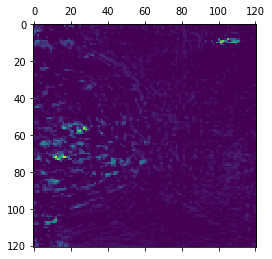

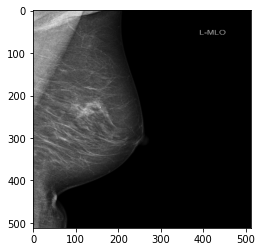

In [ ]:
################# GRADCAM ####################   

model.eval()

# This is an example of a positive mammogram:
patientID = '500'
imageID = '1923583324'
path =  patientID + "_" + imageID + ".png"
image = Image.open(samples_zip.open(path))
image_tensor = transform(image).unsqueeze(0).to(device)

# Ask the model to predict the class for a positive example
pred = model(image_tensor).squeeze() 

# Perform a backward pass on the positive class prediction
pred[1].backward()
# Get the gradients that we recorded
gradients = model.get_activations_gradient().squeeze()

# Weight each of the final convolution channels by corresponding gradients
activations = model.get_activations(image_tensor).detach()
for i in range(5): # Last convolutional layer has an output of 5 channels
    activations[:, i] *= gradients[i]

# Average across all of the activations
heatmap = torch.mean(activations, dim=1).squeeze()
# Apply ReLU to the heatmap so that we only care about positive features
heatmap = np.maximum(heatmap.cpu(), 0)
# Normalize the heatmap:
heatmap /= torch.max(heatmap)

# Show the heatmap:
plt.matshow(heatmap.squeeze())
plt.show()

# Show the original image:
plt.imshow(image_tensor.cpu().squeeze(0).numpy().reshape(512, 512), cmap='gray')


In [ ]:
# This code maps the heatmap onto the actual image and saves that mapping
import cv2
# Code for converting images is found here:
# https://stackoverflow.com/questions/14134892/convert-image-from-pil-to-opencv-format
# and here (again): https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

# Again, This is an example of a positive mammogram:
patientID = '505'
imageID = '322793737'
path =  patientID + "_" + imageID + ".png"
image = np.asarray(Image.open(samples_zip.open(path)))

# Convert grayscale numpy to cv2:
cv_img = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

# Convert heatmap back to numpy
heatmap = np.asarray(heatmap)

# Resize heatmap so its the shape of the original image
heatmap = cv2.resize(heatmap, (cv_img.shape[1], cv_img.shape[0]))
heatmap = np.uint8(255 * heatmap)

# Use special color map from the cv2 library so it looks like a heatmap:
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# Add the two:
superimposed_img = heatmap * 0.4 + cv_img
cv2.imwrite('./mammogramheatmap.jpg', superimposed_img)

True

In [ ]:
################### TESTING #####################
x_test, y_test = meta_dataset.test_sets()
with torch.no_grad():
  total_correct = 0
  total_guessed = 0
    
  class_correct = [0 for i in range(2)]
  class_total = [0 for i in range(2)]
    
  for i, (patientID, imageID) in enumerate(x_test):
      filename = str(patientID) + "_" + str(imageID) + ".png"

      # Get the current mammogram out of the zip file
      current_mammo = Image.open(samples_zip.open(filename))
      image_tensor = transform(current_mammo).squeeze()

      label = y_test[i] # Get true label    
            
      # Put image tensors in format batch, channels, height, width
      image_tensor = image_tensor.to(device).unsqueeze(0).unsqueeze(0)
      
      # Forward pass
      outputs = model(image_tensor)
      predicted = int(torch.argmax(outputs, 1))

      total_guessed += 1
      total_correct += (predicted == label)
      # incremeent correct predictions for each class:
      if (label == predicted):
          class_correct[label] += 1
      class_total[label] += 1
      # For seeing how close we are:
      if i % 1000 == 0:
        print(f'Step: {i} out of {len(y_test)}')
            
  accuracy = 100 * total_correct / total_guessed # Accuracy of the total network
  neg_acc = 100 * class_correct[0] / class_total[0]
  pos_acc = 100 * class_correct[1] / class_total[1]


  print(f'Test set accuracy: {accuracy}')
  print(f'Positive Accuracy: {pos_acc}')
  print(f'Negative Accuracy: {neg_acc}')

Step: 0 out of 10942
Step: 1000 out of 10942
Step: 2000 out of 10942
Step: 3000 out of 10942
Step: 4000 out of 10942
Step: 5000 out of 10942
Step: 6000 out of 10942
Step: 7000 out of 10942
Step: 8000 out of 10942
Step: 9000 out of 10942
Step: 10000 out of 10942
Test set accuracy: 92.63388777188814
Positive Accuracy: 9.44206008583691
Negative Accuracy: 94.4439256699972


In [ ]:
print(f'Out of {class_total[1]} total positive examples, we identified {class_correct[1]} correctly')
print(f'Out of {class_total[0]} total negative examples, we identified {class_correct[0]} correctly')

Out of 233 total positive examples, we identified 22 correctly
Out of 10709 total negative examples, we identified 10114 correctly
